# RAG với Qdrant và Gemini
---------------------------
### Tài tiệu thực hành này được soạn bởi ***Giap Le (Harrison)***
Đây là một bài thực hành cơ bản về việc áp dụng mô hình RAG để tăng độ chính xác của thông tin từ nguồn dữ liệu được kiểm soát và giới
hạn ở __vector database__ (ở đây tôi sử dụng `Qdrant`).
Sau đó sử dụng gemini như một chatbot để tương tác với dữ liệu và người dùng.
Sử dụng kỹ thuật prompt engineering là `few-shot prompting` >> nghĩa là hãy đưa vào cho chatbot model nhiều hơn 1 ngữ cảnh (dữ liệu hoăc/và gợi ý)
và yêu cầu chatbot chỉ sử dụng dữ liệu đã cung cấp làm nguồn thông tin để trả lời.

Ở đây chúng ta sử dụng **sentence-transformers** và pre-trained model: **all-MiniML-L6-v2** từ __HuggingFace__

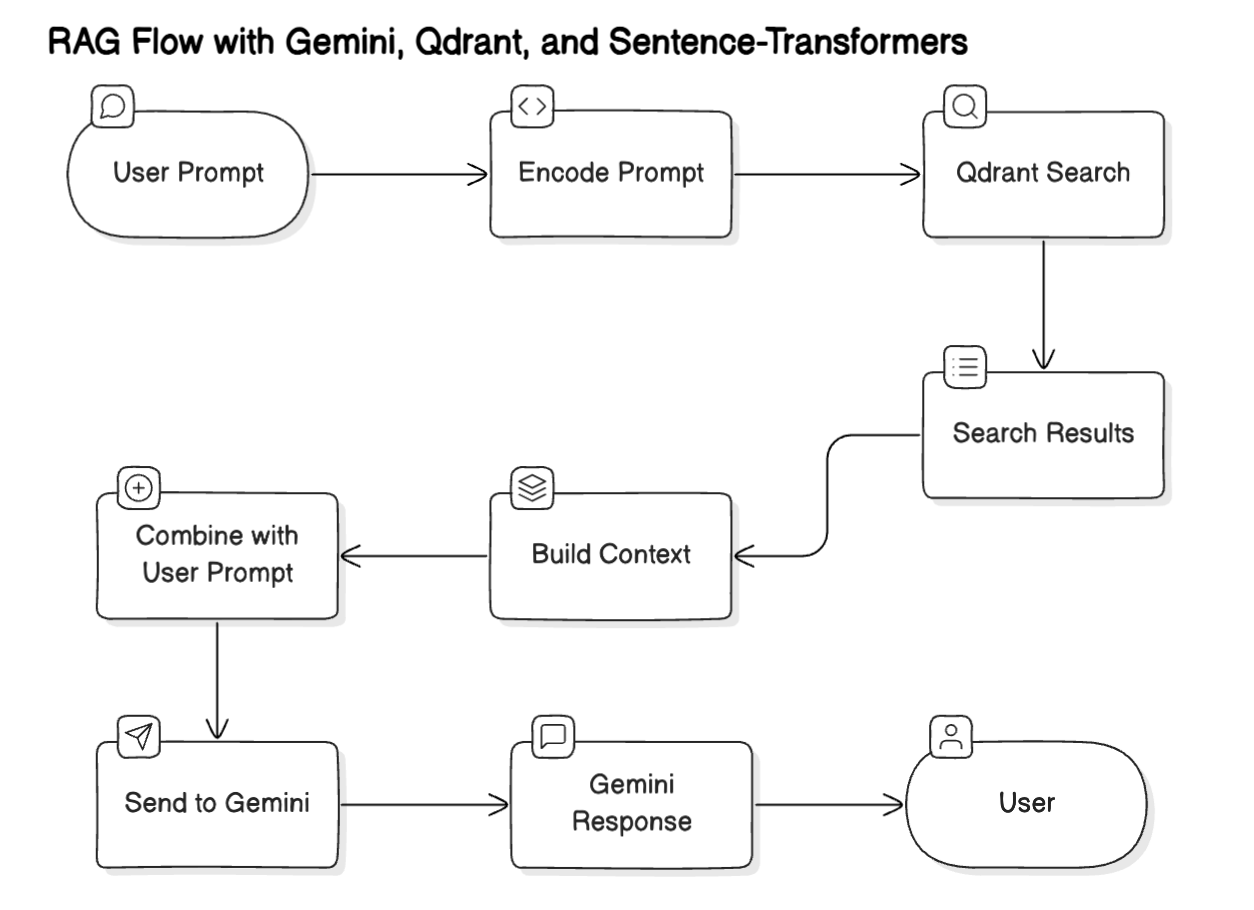
---------------------------

In [ ]:
#Cài đặt các package cần thiết
!pip install transformers #bạn có thể bỏ phần này đi. Tôi để đây để thử với một số model mà không dùng sentence transformer
!pip install numpy
!pip install pandas
!pip install sentence-transformers
!pip install qdrant-client
!pip install google-generativeai

In [ ]:
import transformers
import pandas as pd
import numpy as np
import os

In [204]:
# load dataset
# dataset là một file csv có hơn 100 địa điểm du lịch nổi tiếng ở Việt Nam được tôi tổng hợp ngắn gọn.
# bạn hoàn toàn có thể tạo một dataset riêng theo cách của bạn và sử dụng lại phần encoding phía dưới để tạo vector
# và insert vào Qdrant. Sau đó trải nghiệm với phần search và gemini.
dataset = os.path.join("dataset", "vn_landmark.csv")
df = pd.read_csv(dataset)
df.columns

Index(['name', 'description', 'province'], dtype='object')

## Run Qdrant in Docker
**Dứoi đây là phần hướng dẫn cài đặt và khởi chạy cũng như quản lí dataset/collection của bạn với Qdrant**
(Tôi tạm để English để bạn đọc cho chính xác >> và sẽ translate sang Vietnamese sau khi có bài hướng dẫn chi tiết hơn :) )
You need to manage all of your data using a vector engine. Qdrant lets you store, update or delete created vectors. Most importantly, it lets you search for the nearest vectors via a convenient API.

Dưới đây là 2 bước cơ bản để cài đặt và khởi chạy Qdrant

__Download the Qdrant image from DockerHub.__
``docker pull qdrant/qdrant``

__Start Qdrant inside of Docker.__
``docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant``

__You should see output like this__

`...
[2021-02-05T00:08:51Z INFO  actix_server::builder] Starting 12 workers
[2021-02-05T00:08:51Z INFO  actix_server::builder] Starting "actix-web-service-0.0.0.0:6333" service on 0.0.0.0:6333`

Sau đó bạn truy cập vào địa chỉ localhost trên máy tính của bạn: http://localhost:6333/. Bạn sẽ được đưa tới giao diện của Qdrant.

Tất cả data được upload tới Qdrant được lưu trữ bên trong path này `./qdrant_storage` (thư mục được vẫn được giữ lại cả khi bạn tạo lại container)

In [ ]:
#encode data and add to vector database qdrant
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from sentence_transformers import SentenceTransformer
import csv

# Tải mô hình all-MiniLM-L6-v2
model = SentenceTransformer(
    "all-MiniLM-L6-v2", device="cpu" #nếu trên máy tính cá nhân thì để CPU và trên máy có GPU hoặc collab thì để GPU
)

# Kết nối với Qdrant, lưu ý bạn cần phải start Qdrant server trước bước này
client = QdrantClient(host="localhost", port=6333)

# Tạo collection nếu chưa tồn tại
collection_name = "vietnam_landmarks" #tên của dataset sẽ lưu vào DB
output_size = 384 #output vector là 384 (chiều)
client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=output_size, distance=Distance.COSINE),
)
# Duyệt qua từng dòng trong DataFrame và insert vector vào Qdrant
vectors = model.encode(
    ['Tên địa danh/khu du lịch: ' + row.name + ', Mô tả:' + row.description + ', Địa phương/Tỉnh:' + row.province for row in df.itertuples()],
    show_progress_bar=True,
)

# payload sẽ được tạo bằng cách đọc trực tiếp file csv và sau đó lặp chuyển nó thành list và gán cho payload.
payload=[]
with open(dataset, "r") as fd:
    reader = csv.DictReader(fd)
    payload = list(reader)

# client.upload_collection đã được thay thế bằng 1 hàm mới hơn. Tôi sẽ update sau
client.upload_collection(
    collection_name=collection_name,
    vectors=vectors,
    payload=payload,
    ids=None,  # Vector ids sẽ được tạo và gán tự động
    batch_size=5,  # Số lượng vector sẽ được xử lý trên mỗi lần
)

In [ ]:
# setup function tìm kiếm (sử dụng consine similarity được cài đặt sẵn trong qdrant)
def search(text: str, encoder, qdrant_client, collection_name):
    # Convert text query into vector
    vector = encoder.encode(text).tolist()

    # Use `vector` for search for closest vectors in the collection
    search_result = qdrant_client.search(
        collection_name=collection_name,
        query_vector=vector,
        query_filter=None,  # If you don't want any filters for now
        limit=1,  # 5 the most closest results is enough
    )
    # `search_result` > kết quả tìm kiếm sẽ chứa vector id được tìm thấy cùng với [similarity scores] và payload data được lưu cùng với vector
    payloads = [hit.payload for hit in search_result] #chúng ta chỉ lấy về payload để làm context cho chatbot model
    return payloads

## Hãy tạo API key của bạn với Google AI Studio:
* Truy cập vào đường link này https://aistudio.google.com/app/prompts/new_chat hoặc https://ai.google.dev/aistudio
* Sau đó hãy login bằng acc gmail của bạn
* Sau đó chọn Get API key >> và chọn tiếp Create API Key nếu bạn chưa tạo 1 key nào trước đây hoặc đã xoá nó

In [ ]:
# Thử với gemini
import google.generativeai as genai
#Hãy tạo gemini key thông qua Google AI Stuido trên Google Cloud Web sau đó bạn copy api key vào đây.
gemini_api_key="[put your api key here]"
genai.configure(api_key=gemini_api_key)
gemini_model = genai.GenerativeModel('gemini-1.5-flash')

In [201]:
#Try to search with vector database
#Trong một số trường hợp kết quả tìm kiếm chưa thực sự tốt, tôi đang tìm hiểu nguyên nhân có phải từ thuật toán tìm
#kiếm của qdrant hay do dữ liệu có vấn đề sau khi encoded.
query = "Đảo Bé (An Bình)"
result = search(query, model, client, collection_name)
result

[{'description': 'Nằm cách đảo Lý Sơn khoảng 3km về phía đông, thuộc huyện Lý Sơn. Là hòn đảo nhỏ với bãi biển đẹp và làng chài yên bình.',
  'name': 'Đảo Bé (An Bình)',
  'province': 'Quảng Ngãi'}]

## Chúng ta sẽ thực sự gọi tới gemini API ở đây sau khi đã config API key ở phần trên
Sử dụng kỹ thuật `few-shot prompting` >> để đưa `context data` và các hướng dẫn cho model xử lý thông tin và trả về kết quả
theo cách được chỉ định. Nếu model không tìm thấy dữ liệu trong context data nó sẽ trả lời là không đủ dữ liệu.
Nếu có câu trả lời phù hợp dựa trên context data thì model sẽ trả về kết quả và thêm một số nguồn tham khảo (web hoặc link google search)

In [202]:
#Sử dụng kỹ thuật few-shot prompting.
#Chỉ dẫn cho gemini chỉ trả lời khi câu prompt thực sự liên quan tới dữ liệu được cung cấp (context), nếu không thì hãy trả lời là
#không có đủ thông tin.
from IPython.display import display, Markdown
prompt= 'prompt: ' + query + '. You are expert in landmark guide. Only use context for the answer:' + str(result) + ", and suggest somes relevant questions. Always use suitable output language appropriate to question's language. In case, the context not relevant to the prompt you will output that you have not the data to answe in the same prompt language. Please add some web source to reference if the prompt and output fit with the context"
response = gemini_model.generate_content(prompt)
display(Markdown(response.text))

## Đảo Bé (An Bình)

Đảo Bé (An Bình) là một hòn đảo nhỏ nằm cách đảo Lý Sơn khoảng 3km về phía đông, thuộc huyện Lý Sơn, tỉnh Quảng Ngãi. Nơi đây nổi tiếng với bãi biển đẹp và làng chài yên bình.

**Một số câu hỏi liên quan:**

*  **Bạn có thể cho tôi biết thêm về bãi biển trên Đảo Bé (An Bình)?**
*  **Làm thế nào để đến Đảo Bé (An Bình)?**
*  **Có những hoạt động nào thú vị để làm trên Đảo Bé (An Bình)?**
*  **Có chỗ ở nào trên Đảo Bé (An Bình)?**
*  **Có bất kỳ điểm du lịch nào khác gần Đảo Bé (An Bình)?**

**Nguồn tham khảo:**

*  [Du lịch Lý Sơn](https://www.google.com/search?q=du+l%E1%BB%8Bch+l%C3%BD+s%C6%A1n)
